In [2]:
using NBInclude
@nbinclude("functions.ipynb")
function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

#using MosaicViews
#using ImageShow
using Colors: color_names


All function imported


In [3]:
z_inco_list = load("saved_data/MNIST_image_recovery_25.jld", "z_inco_list")
z_co_list = load("saved_data/MNIST_image_recovery_25.jld", "z_co_list")
x_true_list = load("saved_data/MNIST_image_recovery_25.jld", "x_true_list")
z_est_inco_matrix = load("saved_data/MNIST_image_recovery_25.jld", "z_est_inco_matrix")
z_est_co_matrix = load("saved_data/MNIST_image_recovery_25.jld", "z_est_co_matrix")
epoch = load("saved_data/MNIST_image_recovery_25.jld", "epoch")
m_list = load("saved_data/MNIST_image_recovery_25.jld", "m_list")


epoch_to_load_inco = epoch
dir_inco = "trained_GNN/MNIST_identity_v4"
encoder_μ_inco, encoder_logvar_inco, W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep(dir_inco, epoch_to_load_inco);

# Load the model and test set loader unenforced
epoch_to_load_co = epoch
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, W1_co, W2_co, W3_co, Q_co = load_model_sep(dir_co, epoch_to_load_co);

#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0


# G_inco(z) = decoder_last * decoder(z)
G_inco(z) =Q_inco *W3_inco*relu(W2_inco*relu(W1_inco*z))
G_co(z) = Q_co*relu(W2_co*relu(W1_co*z));


Loading model...Done


Loading model...Done


In [4]:
num = 4
epoch = 40
z_inco = z_inco_list[num, :]
z_co = z_co_list[num, :]
x_true = x_true_list[num, :]
z_est_inco_list = z_est_inco_matrix[num,:,:]
z_est_co_list = z_est_co_matrix[num,:,:]

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end
gif(anim, fps = 1)


InterruptException: InterruptException:

In [129]:
using Plots.PlotMeasures
using Plots
using LaTeXStrings
num = 4
epoch = 40
z_inco = z_inco_list[num, :]
z_co = z_co_list[num, :]
x_true = x_true_list[num, :]
z_est_inco_list = z_est_inco_matrix[num,:,:]
z_est_co_list = z_est_co_matrix[num,:,:]
k = 10
nums = [1,4,5]
meas = [0, 1, 2, 3, 4, 9, 10, 12, 13]
#num = 1
plots = Array{Plots.Plot, 3}(undef,length(nums),length(meas),2)

kwargs = Dict()

for (i,m) in enumerate(meas), (j,num) in enumerate(nums), k in 1:2
       kwargs = Dict()
       kwargs[:axis] =([], false)
       kwargs[:dpi] = 300
       kwargs[:left_margin] = -3mm
       kwargs[:right_margin] = 0mm
       kwargs[:bottom_margin] = -3mm
       #kwargs[:showaxis] = false
       #kwargs[:framestyle] = :none
       #number of measurements
       if j == 1 && k == 1
              if i==1
                     kwargs[:title] = L"signal" 
                     kwargs[:titlefontsize] = 10
              else
                     kwargs[:title] = L"m = %$(m_list[m])"
                     kwargs[:titlefontsize] = 10
                     kwargs[:titlefontvalign] = :bottom
              end
       end

       if j == length(nums) && k == 2
              kwargs[:bottom_margin] = 2mm
       end

       #coherence label
       if i == 1
              kwargs[:guidefontsize] = 8
              kwargs[:left_margin] = 3mm
              if k == 1
                     kwargs[:ylabel] = L"\alpha = 0.81"
              else
                     kwargs[:ylabel] = L"\alpha = 0.96"
              end
       end

       #margin
       if k == 1 && j > 1
              kwargs[:top_margin] = 7mm
       else
              kwargs[:top_margin] = 0mm
       end
       #kwargs[:framestyle] = :none
       #plot
       if i == 1
              plots[j, i, k] = plot(colorview(Gray, reshape(x_true_list[num,:], 28,28)' ); kwargs...)
       else
           
              if k == 1
                     plots[j, i, k] = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ); kwargs...)
              else
                     plots[j, i, k] = plot(colorview(Gray, reshape(G_co(z_est_co_matrix[num,:, m]), 28,28)' ); kwargs...)
              end
       end

       # if j == 1
       #        if i == 1
       #               plots[j, i, 1] = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),axis=([], false), ylabel="α = 0.81",guidefontsize=5, titlefontsize=12,title = L"m = %$(m_list[m])", topmargin=2mm)
       #        else
       #               plots[j, i, 1] = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),axis=([], false), titlefontsize=12,title = L"m = %$(m_list[m])", topmargin=2mm)
       #        end
       # else
       #        if i == 1
       #               plots[j, i, 1] = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),axis=([], false), ylabel = "α = 0.96", guidefontsize=5, topmargin=2mm)
              
       #        else

       #               plots[j, i, 1] = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),axis=([], false), topmargin=2mm)
       #        end
       # end
       # plots[j, i, 2] = plot(colorview(Gray, reshape(G_co(z_est_co_matrix[num,:, m]), 28,28)' ), axis=([], false))
       #, title = L"m = %$(m_list[m])",
end
plots = reshape(plots, length(nums), length(meas)*2)

# num = 1
# m = 2

# plot(
#                 plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),framestyle = :none, titlefontsize	=14,title = L"m = %$(m_list[m])", topmargin=10mm ),
#                 plot(colorview(Gray, reshape(G_co(z_est_co_matrix[num,:, m]), 28,28)' ),framestyle = :none),
#                 layout = @layout([a ; b])
#                 )
#plot(plots...)
# nums = [1,4,5]
# meas = [ 1, 2, 3, 4, 9, 10, 12 ,13]
# for index in 1:length(meas)
#     m = meas[index]
#     push!(p, plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),framestyle = :none, titlefontsize	=14,title = L"m = %$(m_list[m])", topmargin=10mm )) #, title = L"m = %$(m_list[m])",
#     push!(q, plot(colorview(Gray, reshape(G_co(z_est_co_matrix[num,:, m]), 28,28)' ),framestyle = :none))
# end
#plot1 = plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8], p[9],
#    q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8], q[9],
#       layout = (2,9), size = (1200,250))


       #savefig(plot1, "figures/Image_recov_1.pdf")


       

3×18 Matrix{Plots.Plot}:
 Plot{Plots.GRBackend() n=1}  …  Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}     Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}     Plot{Plots.GRBackend() n=1}

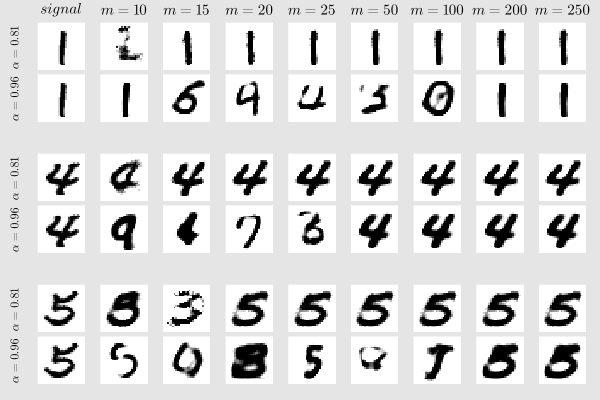

In [130]:
plot_save = plot(plots[1,:]..., plots[2,:]..., plots[3,:]..., layout = @layout([grid(2, length(meas)) ; grid(2, length(meas)) ; grid(2, length(meas))]), background_color=:grey90)

In [93]:
length(meas)

9

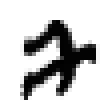

In [13]:
colorview(Gray, reshape(x_true, 28,28))

In [11]:
length(x_true)

784

In [131]:
savefig(plot_save, "figures/full_number_recovery_plot_v3.pdf")

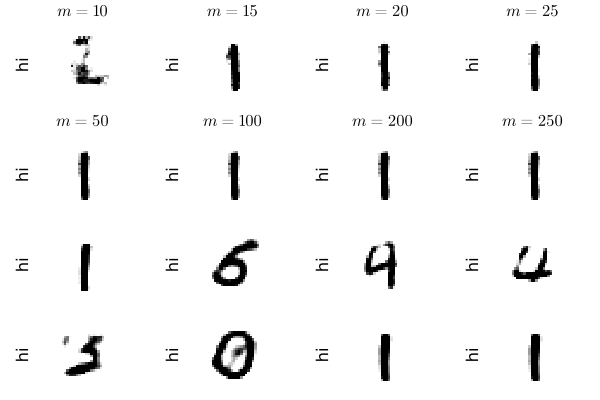

In [70]:
plot1 = plot(plots[1,:]...)
ylabel!("hi")
plot(plot1)

In [5]:
num = 1
z_inco = z_inco_list[num,:]
z_est_inco_list = z_est_inco_matrix[num,:,:]

recon_error = []
for i in 1:length(m_list)
    recon_error = relative_error(G_inco(z_inco), G_inco(z_est_inco_list[:, i]))
end

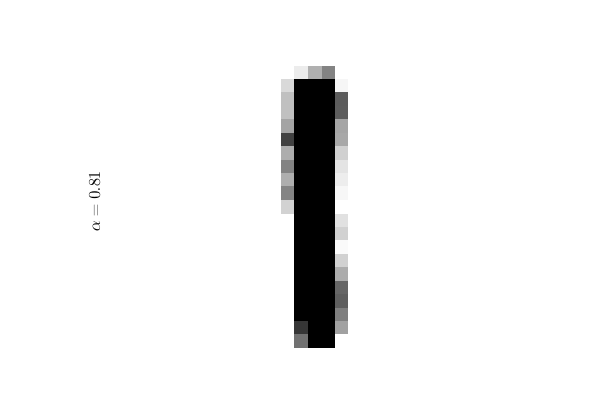

In [6]:
plot(colorview(Gray, reshape(G_inco(z_inco_list[num,:]), 28,28)' ),framestyle = :box,titlefontsiz =8, axis=([], false), ylabel = L"\alpha = 0.81" )

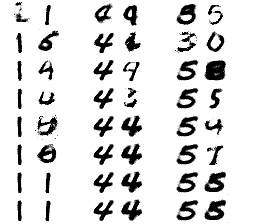

In [20]:
# rec_tensor = []
# for num in 1:9
#     rec_inco_tensor = zeros(28,28,length(m_list))
#     rec_co_tensor = zeros(28,28,length(m_list))
#     for m in 1:length(m_list)
#         rec_inco_tensor[:,:,m] = reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)'
#         rec_co_tensor[:,:,m] = reshape(G_inco(z_est_co_matrix[num,:, m]), 28,28)'
#     end
#     cat(rec_inco_tensor, rec_co_tensor; dims = 2 )
#     push!(rec_tensor, )
# end
nums = [1,4,5]
meas = [ 1, 2, 3, 4, 9, 10, 12 ,13]
image = ones(28*length(meas),5)

for num in nums
    rec_inco_tensor = zeros(28,28,length(meas))
    rec_co_tensor = zeros(28,28,length(meas))
    for index in 1:length(meas)
        m = meas[index]
        rec_inco_tensor[:,:,index] = reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)
        rec_co_tensor[:,:,index] = reshape(G_inco(z_est_co_matrix[num,:, m]), 28,28)
    end
    # print(size(rec_co_tensor))
    image = hcat(image, reshape(rec_inco_tensor, 28,28*length(meas) )', reshape(rec_co_tensor, 28,28*length(meas) )', ones(28*length(meas),28) )
end




# cat(rec_inco_tensor, rec_co_tensor; dims = 2 )
# push!(rec_tensor, )


colorview(Gray, image)

In [22]:
plot(plot1, plot2, plot3, layout = (3,1))


UndefVarError: UndefVarError: plot2 not defined

In [21]:
num = 1
p1 = plot(colorview(Gray, reshape(G_inco(z_inco[num,:]), 28,28)' )); q1 = plot(colorview(Gray, reshape(G_inco(z_co[num,:]), 28,28)' ));
p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[1]]), 28,28)' )); q2 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[1]]), 28,28)' ));

p3 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[2]]), 28,28)' )); q3 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[2]]), 28,28)' ));

p4 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[3]]), 28,28)' )); q4 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[3]]), 28,28)' ));
p5 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[4]]), 28,28)' )); q5 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[4]]), 28,28)' ));
p6 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[5]]), 28,28)' )); q6 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[5]]), 28,28)' ));
p3 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[2]]), 28,28)' )); q3 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[2]]), 28,28)' ));
p3 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[2]]), 28,28)' )); q3 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[2]]), 28,28)' ));
p3 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[2]]), 28,28)' )); q3 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[2]]), 28,28)' ));
p3 = plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m[2]]), 28,28)' )); q3 = plot(colorview(Gray, reshape(G_inco(z_est_co_matrix[num,:, m[2]]), 28,28)' ));




q2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ))
p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ))
p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ))


DimensionMismatch: DimensionMismatch("second dimension of A, 20, does not match length of x, 1")

In [9]:
m_list

13-element Vector{Int64}:
  10
  15
  20
  25
  30
  35
  40
  45
  50
 100
 150
 200
 250